In [0]:
!nvidia-smi

Wed Apr  1 21:58:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Intent Recognition with BERT using Keras and TensorFlow 2

BERT (Bidirectional Encoder Representations from Transformers) is a recent paper published by researchers at Google AI Language. It has caused a stir in the Machine Learning community by presenting state-of-the-art results in a wide variety of NLP tasks, including Question Answering (SQuAD v1.1), Natural Language Inference (MNLI), and others.
BERT’s key technical innovation is applying the bidirectional training of Transformer, a popular attention model, to language modelling. This is in contrast to previous efforts which looked at a text sequence either from left to right or combined left-to-right and right-to-left training. The paper’s results show that a language model which is bidirectionally trained can have a deeper sense of language context and flow than single-direction language models. In the paper, the researchers detail a novel technique named Masked LM (MLM) which allows bidirectional training in models in which it was previously impossible.

BERT is a pre-trained Transformer Encoder stack. It is trained on Wikipedia and the Book Corpus dataset. It has two versions - Base (12 encoders) and Large (24 encoders).

BERT is built on top of multiple clever ideas by the NLP community. Some examples are ELMo, The Transformer, and the OpenAI Transformer.

ELMo introduced contextual word embeddings (one word can have a different meaning based on the words around it). The Transformer uses attention mechanisms to understand the context in which the word is being used. That context is then encoded into a vector representation. In practice, it does a better job with long-term dependencies.

BERT makes use of Transformer, an attention mechanism that learns contextual relations between words (or sub-words) in a text. In its vanilla form, Transformer includes two separate mechanisms — an encoder that reads the text input and a decoder that produces a prediction for the task. Since BERT’s goal is to generate a language model, only the encoder mechanism is necessary. The detailed workings of Transformer are described in a paper by Google.
As opposed to directional models, which read the text input sequentially (left-to-right or right-to-left), the Transformer encoder reads the entire sequence of words at once. Therefore it is considered bidirectional, though it would be more accurate to say that it’s non-directional. This characteristic allows the model to learn the context of a word based on all of its surroundings (left and right of the word).

The diagram below is a high-level description of the Transformer encoder. 
![alt text](https://miro.medium.com/max/1400/0*ViwaI3Vvbnd-CJSQ.png)

The input is a sequence of tokens, which are first embedded into vectors and then processed in the neural network. The output is a sequence of vectors of size H, in which each vector corresponds to an input token with the same index.
When training language models, there is a challenge of defining a prediction goal. Many models predict the next word in a sequence (e.g. “The child came home from ___”), a directional approach which inherently limits context learning. To overcome this challenge, BERT uses two training strategies:

**Masked LM (MLM)**

Before feeding word sequences into BERT, 15% of the words in each sequence are replaced with a [MASK] token. The model then attempts to predict the original value of the masked words, based on the context provided by the other, non-masked, words in the sequence. In technical terms, the prediction of the output words requires:



1.   Adding a classification layer on top of the encoder output.
2.   Multiplying the output vectors by the embedding matrix, transforming them into the vocabulary dimension.
3. Calculating the probability of each word in the vocabulary with softmax.

The BERT loss function takes into consideration only the prediction of the masked values and ignores the prediction of the non-masked words. As a consequence, the model converges slower than directional models, a characteristic which is offset by its increased context awareness

**Next Step Prediction**

In the BERT training process, the model receives pairs of sentences as input and learns to predict if the second sentence in the pair is the subsequent sentence in the original document. During training, 50% of the inputs are a pair in which the second sentence is the subsequent sentence in the original document, while in the other 50% a random sentence from the corpus is chosen as the second sentence. The assumption is that the random sentence will be disconnected from the first sentence.

To help the model distinguish between the two sentences in training, the input is processed in the following way before entering the model:

1. A [CLS] token is inserted at the beginning of the first sentence and a [SEP] token is inserted at the end of each sentence.
2. A sentence embedding indicating Sentence A or Sentence B is added to each token. Sentence embeddings are similar in concept to token embeddings with a vocabulary of 2.
3. A positional embedding is added to each token to indicate its position in the sequence. The concept and implementation of positional embedding are presented in the Transformer paper.

![alt text](https://miro.medium.com/max/1400/0*m_kXt3uqZH9e7H4w.png)

To predict if the second sentence is indeed connected to the first, the following steps are performed:

1. The entire input sequence goes through the Transformer model.
2. The output of the [CLS] token is transformed into a 2×1 shaped vector, using a simple classification layer (learned matrices of weights and biases).
3. Calculating the probability of IsNextSequence with softmax.







BERT can be used for a wide variety of language tasks, while only adding a small layer to the core model:

1. Classification tasks such as sentiment analysis are done similarly to Next Sentence classification, by adding a classification layer on top of the Transformer output for the [CLS] token.
2. In Question Answering tasks (e.g. SQuAD v1.1), the software receives a question regarding a text sequence and is required to mark the answer in the sequence. Using BERT, a Q&A model can be trained by learning two extra vectors that mark the beginning and the end of the answer.
3. In Named Entity Recognition (NER), the software receives a text sequence and is required to mark the various types of entities (Person, Organization, Date, etc) that appear in the text. Using BERT, a NER model can be trained by feeding the output vector of each token into a classification layer that predicts the NER label.

In [3]:
!pip install tensorflow-gpu >> /dev/null

ERROR: tensorflow 2.2.0rc2 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.


In [4]:
!pip install --upgrade grpcio >> /dev/null

ERROR: tensorflow 2.2.0rc2 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.


In [0]:
!pip install tqdm  >> /dev/null

In [0]:
!pip install bert-for-tf2 >> /dev/null

In [0]:
!pip install sentencepiece >> /dev/null

In [8]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data

The data contains various user queries categorized into seven intents. 

In [9]:
!gdown --id 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 --output train.csv
!gdown --id 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w --output valid.csv
!gdown --id 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF --output test.csv

Downloading...
From: https://drive.google.com/uc?id=1OlcvGWReJMuyYQuOZm149vHWwPtlboR6
To: /content/train.csv
100% 799k/799k [00:00<00:00, 111MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w
To: /content/valid.csv
100% 43.3k/43.3k [00:00<00:00, 38.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF
To: /content/test.csv
100% 43.1k/43.1k [00:00<00:00, 65.1MB/s]


In [0]:
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

In [0]:
train = train.append(valid).reset_index(drop=True)

In [12]:
train.shape

(13784, 2)

In [13]:
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


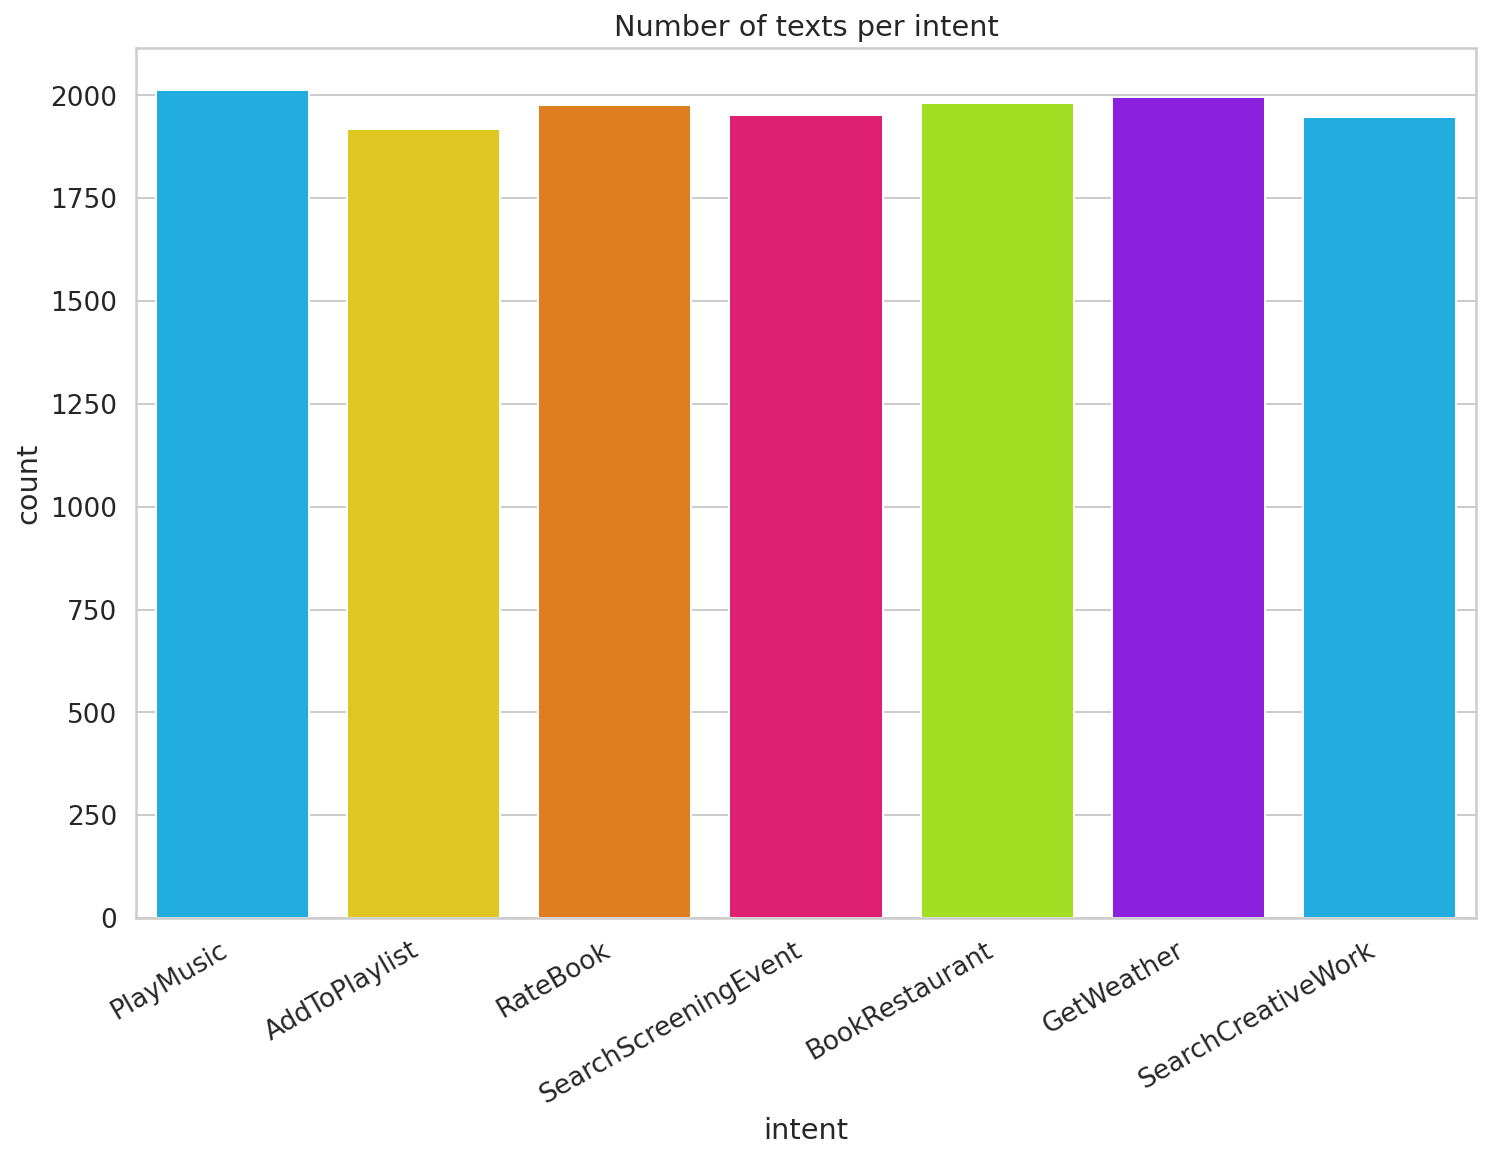

In [14]:
chart = sns.countplot(train.intent, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

# Intent Recognition with BERT

In [15]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-04-06 23:12:11--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   138MB/s    in 2.8s    

2020-04-06 23:12:14 (138 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [16]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [0]:
os.makedirs("model", exist_ok=True)

In [0]:
!mv uncased_L-12_H-768_A-12/ model

In [0]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

We need to convert the raw texts into vectors that we can feed into our model. We’ll go through 3 steps:

Tokenize the text

Convert the sequence of tokens into numbers

Pad the sequences so each one has the same length

In [0]:
class IntentDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "intent"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [0]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [22]:
tokenizer.tokenize("The Dark Knight Rises!")

['the', 'dark', 'knight', 'rises', '!']

In [23]:
tokens = tokenizer.tokenize("The Dark Knight Rises!")
tokenizer.convert_tokens_to_ids(tokens)

[1996, 2601, 5000, 9466, 999]

In [0]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

## Training

In [25]:
classes = train.intent.unique().tolist()

data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

13784it [00:03, 3809.40it/s]
700it [00:00, 3643.88it/s]


max seq_len 38


In [26]:
data.train_x.shape

(13784, 38)

In [27]:
data.train_x[0]

array([  101,  4952,  2000,  2225,  3676,  2213,  2632, 25438, 27395,
        2006,  8224,  2189,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0])

In [28]:
data.train_y[0]

0

In [29]:
data.max_seq_len

38

In [30]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 38, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fc26674bc18> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 38)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 38, 768)           108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 5383  

Fine-tuning models like BERT is both art and doing tons of failed experiments. Fortunately, there are some recommendations:

Batch size: 16, 32

Learning rate (Adam): 5e-5, 3e-5, 2e-5

Number of epochs: 2 - 5

In [0]:
model.compile(
  optimizer=keras.optimizers.Adam(5e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [34]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=3,
  callbacks=[tensorboard_callback]
)

Train on 12405 samples, validate on 1379 samples
Epoch 1/3
12405/12405 [==============================] - 242s 20ms/sample - loss: 1.2358 - acc: 0.9338 - val_loss: 1.1848 - val_acc: 0.9804
Epoch 2/3
12405/12405 [==============================] - 243s 20ms/sample - loss: 1.2009 - acc: 0.9645 - val_loss: 1.1954 - val_acc: 0.9695
Epoch 3/3
12405/12405 [==============================] - 243s 20ms/sample - loss: 1.2093 - acc: 0.9563 - val_loss: 1.2018 - val_acc: 0.9630


## Evaluation

In [0]:
%load_ext tensorboard

In [36]:
%tensorboard --logdir log

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2020-04-06 23:26:05.329289: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-04-06 23:26:05.329393: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-04-06 23:26:05.329404: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/

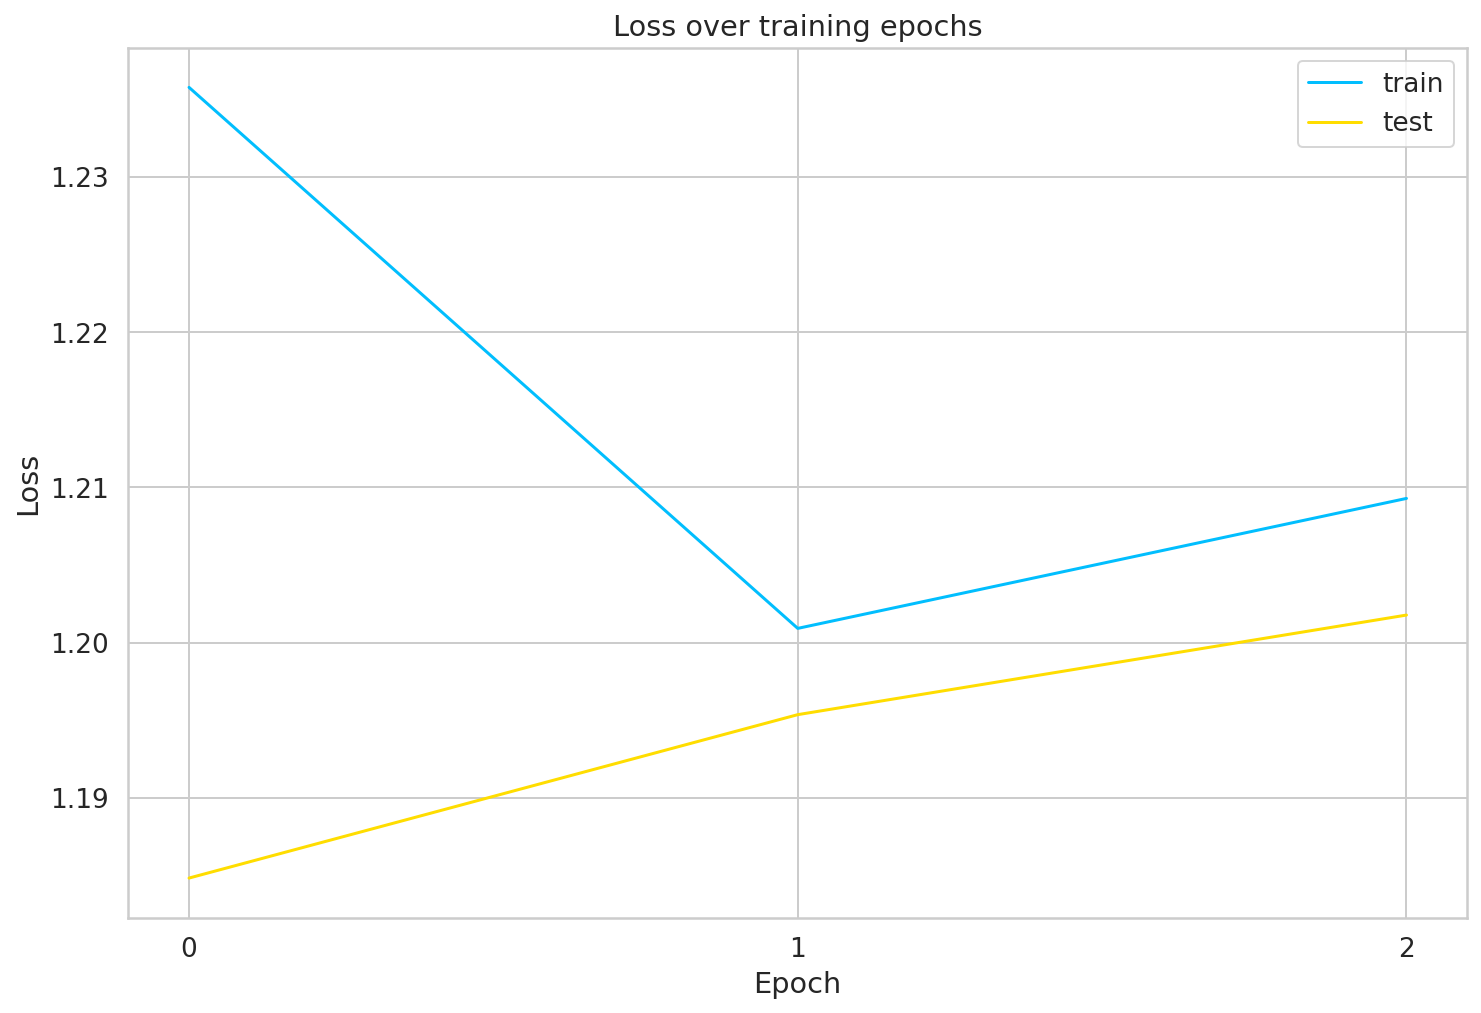

In [37]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

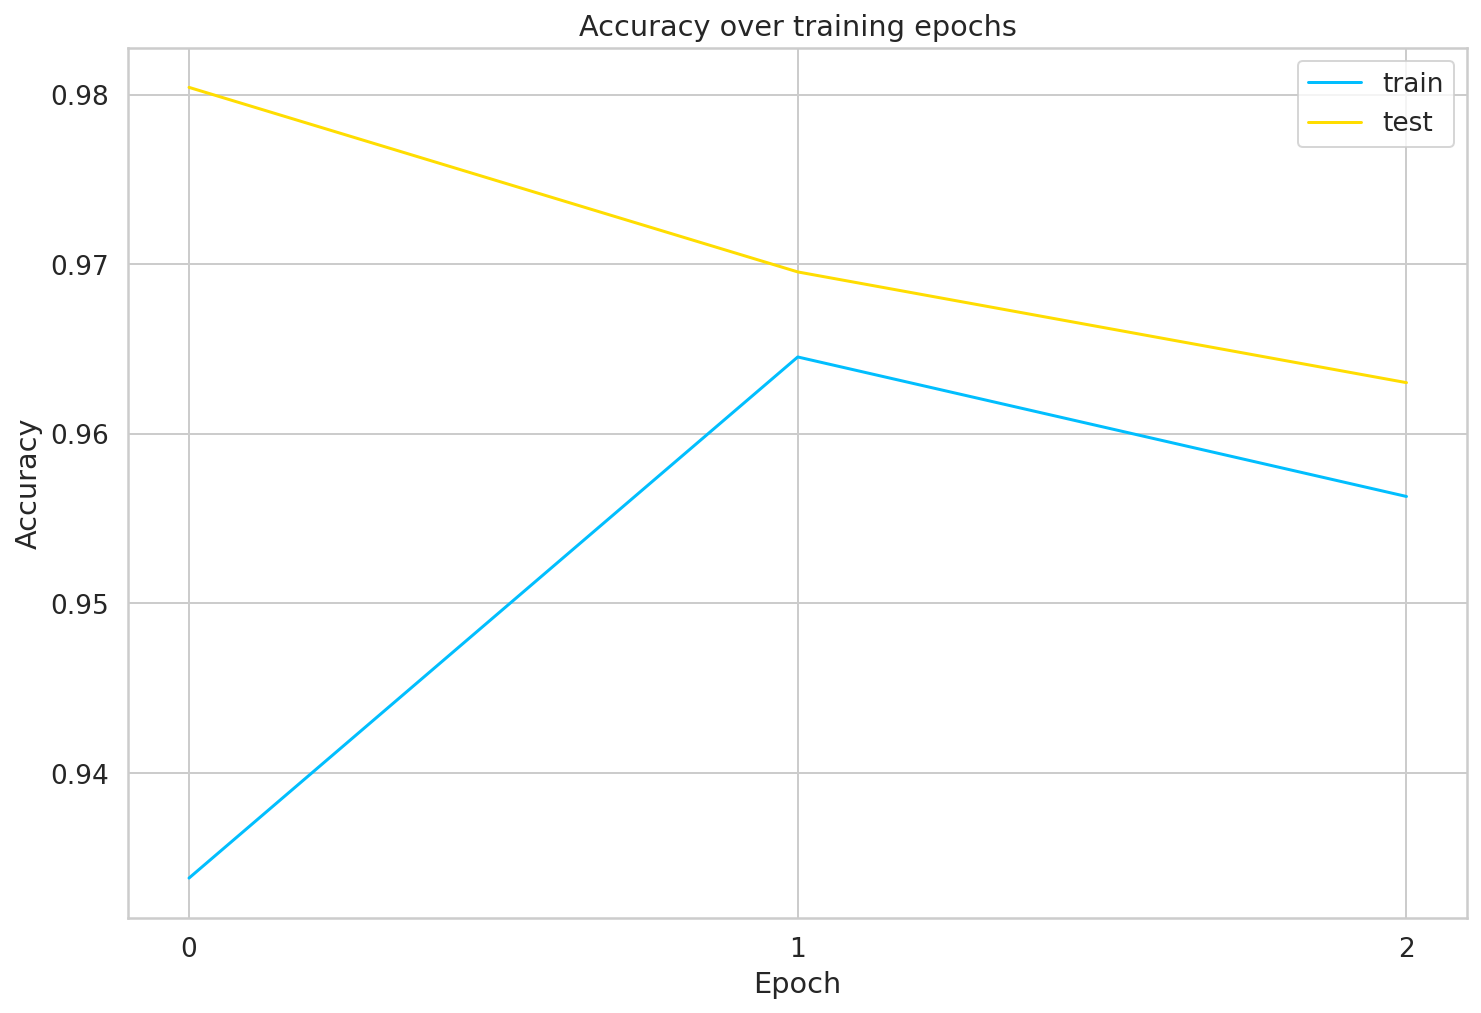

In [38]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [39]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

700/700 [==============================] - 2s 2ms/sample - loss: 1.2283 - acc: 0.9357
train acc 0.96096927
test acc 0.9357143


In [0]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [41]:
print(classification_report(data.test_y, y_pred, target_names=classes))

                      precision    recall  f1-score   support

           PlayMusic       0.99      0.77      0.86        86
       AddToPlaylist       0.97      1.00      0.98       124
            RateBook       0.96      1.00      0.98        80
SearchScreeningEvent       0.90      0.93      0.91       107
      BookRestaurant       0.98      0.99      0.98        92
          GetWeather       1.00      0.95      0.98       104
  SearchCreativeWork       0.80      0.90      0.85       107

            accuracy                           0.94       700
           macro avg       0.94      0.93      0.94       700
        weighted avg       0.94      0.94      0.94       700



In [0]:
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

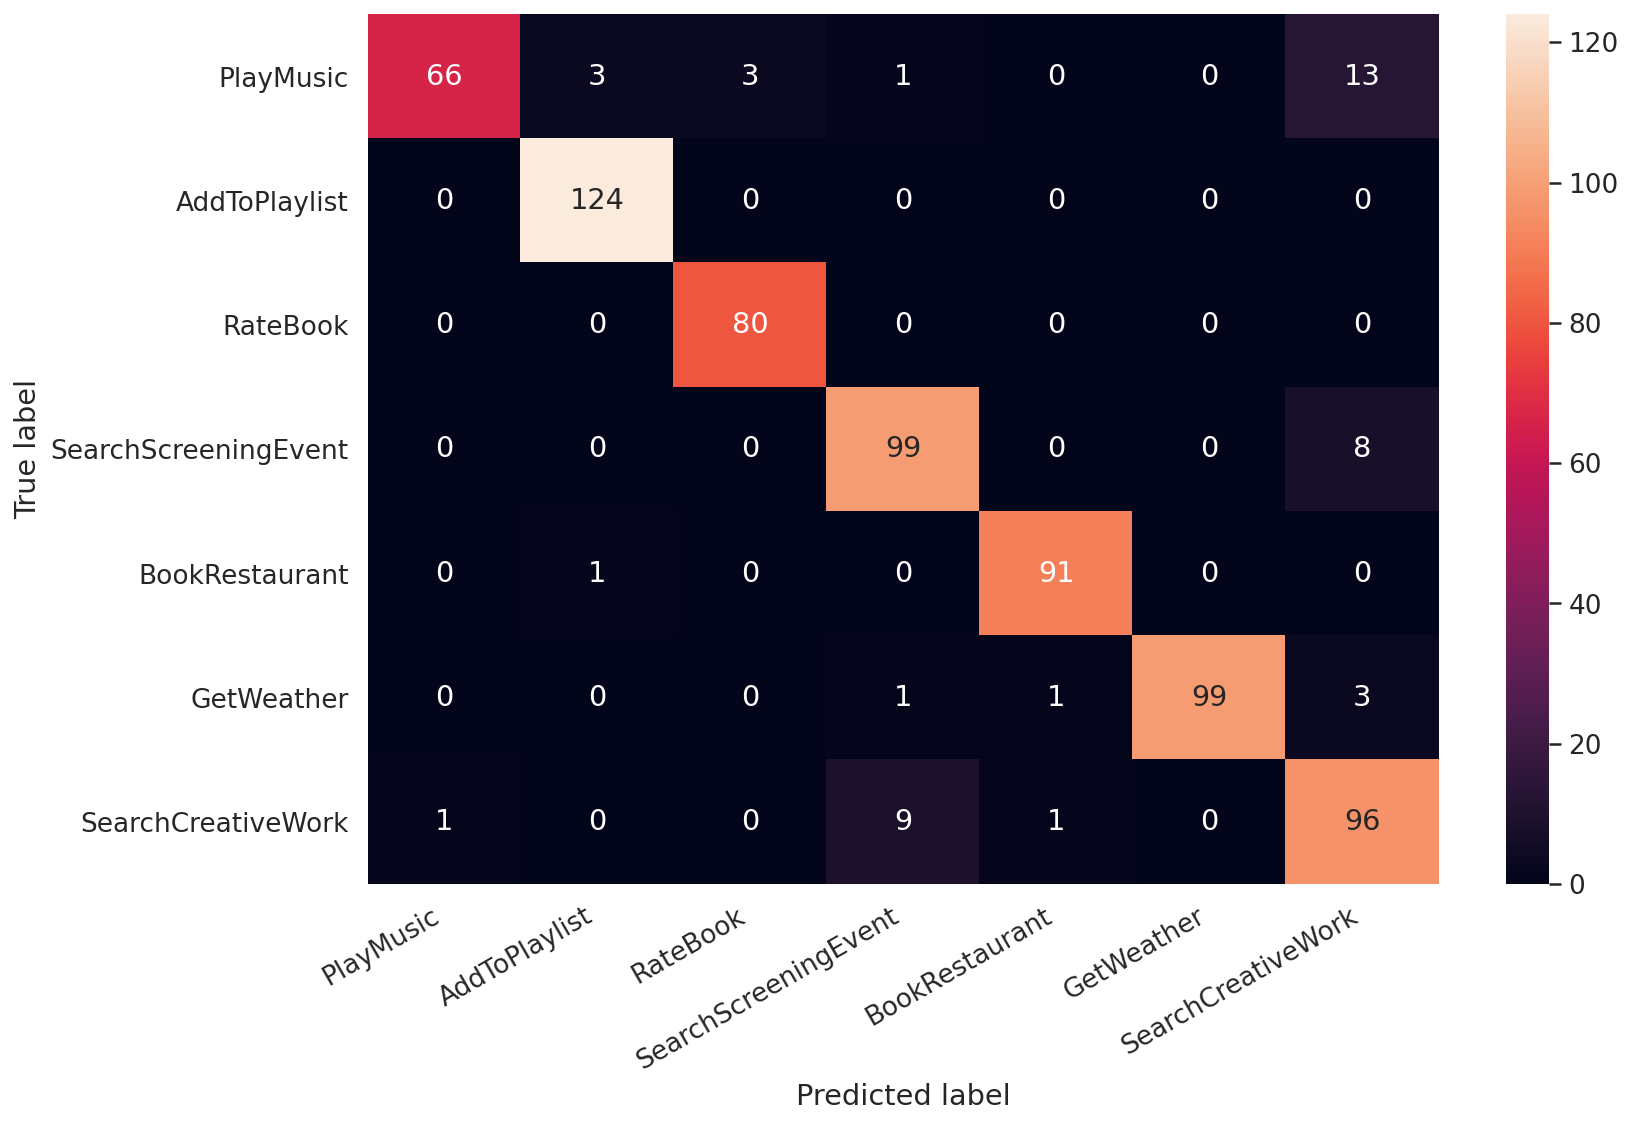

In [43]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [47]:
sentences = [
  "I want to eat at Eduardo's tonight",
  "Put Graduation in Liked Songs",
  "Where can I watch the next show of Hamilton?"
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nintent:", classes[label])
  print()

text: I want to eat at Eduardo's tonight 
intent: BookRestaurant

text: Put Graduation in Liked Songs 
intent: AddToPlaylist

text: Where can I watch the next show of Hamilton? 
intent: SearchCreativeWork



# References

- https://mccormickml.com/2019/07/22/BERT-fine-tuning/
- https://github.com/snipsco/nlu-benchmark/tree/master/2017-06-custom-intent-engines
- https://jalammar.github.io/illustrated-bert/
- https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03
- https://www.reddit.com/r/MachineLearning/comments/ao23cp/p_how_to_use_bert_in_kaggle_competitions_a/